<a href="https://colab.research.google.com/github/hiamitabha/course/blob/master/kernel_vector_sign_language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Choose device out of CPU, GPU, or TPU

Choose _DEVICE out of CPU, GPU, TPU, or FLOYD
Choose _MODEL out of Convolution Neural Network (CNN) or RESNET (Resnet-50 available in Keras)

Choose _OPTIMZER out of all the optimizers available in Keras: SGD, RMSprop, Adagrad, AdaDelta, Adam, AdaMax, Nadam.

In [0]:
_DEVICE = "GPU"
_MODEL = "CNN"
_OPTIMIZER = "SGD"

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

def get_cpu_device_name():
    """"
        Get the device name of a GPU device
    """"
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        print (device_name) 
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    #GPU count and name
    !nvidia-smi -L
    return device_name

def get_tpu_strategy():
    """"
        Get the tpu_strategy for a TPU
    """"
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    return tpu_strategy

if _DEVICE == "TPU":
    device_name = 'tpu'
    tpu_strategy = get_tpu_strategy()
elif _DEVICE == "GPU":
    device_name = get_gpu_device_name()
elif _DEVICE == "CPU":
    device_name = '/cpu:0'
elif _DEVICE == "FLOYD":
    print ('Running on floydhub with CPU')
elif _DEVICE == "FLOYDGPU":
    print ('Running on floydhub with GPU')
    device_name = get_gpu_device_name()
else:
    print ("Incorrect device option")

Tensorflow version 2.2.0-rc2
Found GPU at: /device:GPU:0
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-fe901c0c-5d97-a475-34a4-88faa86a271f)


In [0]:
try:
    import tensorflow.keras
    from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
    from tensorflow.keras.models import Sequential, Model, model_from_json
    from tensorflow.keras.preprocessing.image import img_to_array
    from tensorflow.keras import applications
    from tensorflow.keras.callbacks import EarlyStopping
except ImportError as exc:
    sys.exit("No keras")

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Any results you write to the current directory are saved as output.

In [0]:
try:
    from PIL import Image
except ImportError:
    sys.exit("Cannot import from PIL: Do `pip3 install --user Pillow` to install")

In [0]:
try:
    from sklearn.model_selection import train_test_split
except ImportError as exc:
    sys.exit("Cannot import scikit")

In [0]:
class NetworkConstants():  # pylint: disable=too-few-public-methods
    """Constant values used as image and network parameters."""

    # Width of images passed to the network
    IMAGE_WIDTH: int = 200

    # Height of images passed to the network
    IMAGE_HEIGHT: int = 200

    # Currently set to 2 alphabet images and 1 background image class
    # Number of classes that the network can categorize
    NUM_CLASSES: int = 27

    # The fraction of images passed to the network during training that should
    # be used as a validation set. Range: 0 to 1
    VALIDATION_SPLIT: float = 0.2

    # The fraction of images passed to the network during training that should
    # be used as a test set. Range: 0 to 1
    TEST_SPLIT: float = 0.2

    # Number of epochs on which to train the network
    EPOCHS: int = 20


In [0]:
from zipfile import ZipFile
import io
class SignLanguageRecognizer():
    """Recognize sign language hand signals using Vector's camera feed.

    A convolutional neural network is used to predict the hand signs.
    The network is built with a Keras Sequential model with a TensorFlow backend.
    """

    def __init__(self):
        """
        device_name = tf.test.gpu_device_name()
        if device_name != '/device:GPU:0':
            print(
               '\n\nThis error most likely means that this notebook is not '
               'configured to use a GPU.  Change this in Notebook Settings via the '
               'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
            raise SystemError('GPU device not found')
        """
        self.training_images: np.ndarray = None
        self.training_labels: np.ndarray = None
        self.test_images: np.ndarray = None
        self.test_labels: np.ndarray = None
        self.model: tf.keras.engine.sequential.Sequential = None
        self.graph: tf.python.framework.ops.Graph = tf.compat.v1.get_default_graph()
        if _OPTIMZER == "SGD":
            self.optimizer = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        elif _OPTIMZER == "ADAM":
            self.optimizer = tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
            
    def load_datasets(self, datasetFile) -> None:
        """Load the training and test datasets required to train the model.
  
        """

        if not dataset:
            sys.exit("Cannot load dataset.")

        images = []
        labels = []
        countLabels = dict()
        count = 0
        with ZipFile(datasetFile) as archive:
            for entry in archive.infolist():
                filename = entry.filename.split('/')[-1]
                if filename.endswith(".png") and not filename.startswith("."):
                   count += 1
                   #if (count % 4 == 0):
                   #    continue
                   image_data = archive.read(entry.filename)
                   data = io.BytesIO(image_data)
                   image = Image.open(data)
                   if image:    
                       # Convert image to an array with shape (image_width, image_height, 1)
                       image_data = img_to_array(image)
                       images.append(image_data)

                       if filename.startswith("background"):
                           # Use the last class to denote an unknown/background image
                           label = NetworkConstants.NUM_CLASSES - 1
                       else:
                           # Use ordinal value offsets to denote labels for all alphabets
                           label = ord(filename[0]) - 97

                       labels.append(label)
                       if countLabels.get(chr(label + 97)) is not None:
                           countLabels[chr(label + 97)] += 1
                       else:
                           countLabels[chr(label + 97)] = 1
                   else:
                       print ("Not using this file")
                       continue
                   

        print ("Here is a count of labels from our repository")
        print (countLabels)
        # Normalize the image data
        images = np.array(images, dtype="float") / 255.0
        # Convert labels to a numpy array
        labels = np.array(labels)

        # Split data read in to training and test segments
        self.training_images, self.test_images, self.training_labels, self.test_labels = train_test_split(images, labels, 
                                                                                                          test_size=NetworkConstants.TEST_SPLIT)

        # Convert array of labels in to binary classs matrix
        self.training_labels = tf.keras.utils.to_categorical(self.training_labels, num_classes=NetworkConstants.NUM_CLASSES)
        self.test_labels = tf.keras.utils.to_categorical(self.test_labels, num_classes=NetworkConstants.NUM_CLASSES)
    
    def create_cnn_model(self) -> None:
        """Creates a convolutional neural network model with the following architecture:

        ConvLayer -> MaxPoolLayer -> ConvLayer -> MaxPoolLayer -> ConvLayer ->
        Dropout -> Flatten -> Dense -> Dropout -> Dense

        .. code-block:: python

            recognizer = SignLanguageRecognizer()
            recognizer.load_datasets("/path/to/dataset_root_folder")
            recognizer.create_model()
        """
        self.model = Sequential()
        self.model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(NetworkConstants.IMAGE_WIDTH, 
                                                                                      NetworkConstants.IMAGE_HEIGHT, 1)))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))

        self.model.add(Dropout(0.25))
        self.model.add(Flatten())

        self.model.add(Dense(128, activation="relu"))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(NetworkConstants.NUM_CLASSES, activation="softmax"))

        
        self.model.compile(loss=tf.keras.losses.categorical_crossentropy,
                            optimizer=self.optimizer,
                            metrics=['accuracy'])
        self.model.summary()
    
    def create_resnet_model(self) -> None:
        base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape=(NetworkConstants.IMAGE_WIDTH, 
                                                                                      NetworkConstants.IMAGE_HEIGHT, 1))
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.25)(x)
        predictions = Dense(NetworkConstants.NUM_CLASSES, activation= 'softmax')(x)
        self.model = Model(inputs = base_model.input, outputs = predictions)
        self.model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    def train_model(self, epochs: int = NetworkConstants.EPOCHS, verbosity: int = 1) -> None:
        """Trains the model off of the training and test data provided

        .. code-block:: python

            recognizer = SignLanguageRecognizer()
            recognizer.load_datasets("/path/to/dataset_root_folder")
            recognizer.create_model()
            recognizer.train_model()
        """

        if self.training_images.size == 0 or self.training_labels.size == 0:
            sys.exit("Training dataset is empty. Build a dataset with `data_gen.py` before training the model.")
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        history = self.model.fit(self.training_images,
                       self.training_labels,
                       epochs=epochs,
                       verbose=verbosity,
                       validation_split=NetworkConstants.VALIDATION_SPLIT,
                       callbacks=[es])
        return history
      
    
    def save_model(self, model_config_filename: str, model_weights_filename: str) -> None:
        """Saves a model's config and weights for latter use.

        .. code-block:: python

            recognizer = SignLanguageRecognizer()
            recognizer.load_datasets(args.dataset_root_folder)
            recognizer.create_model()
            recognizer.train_model()
            recognizer.save_model("/path/to/model_config_filename", "/path/to/model_weights_filename")
        """
        json_model = self.model.to_json()
        # Save the network architecture
        with open(model_config_filename, "w") as file:
            file.write(json_model)
        # Save the model's assigned weights
        self.model.save_weights(model_weights_filename)

    def printme(self):
        print (self.training_images[0])
        
    

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:

dataset = '/content/drive/My Drive/training-a-robot-to-understand-sign-language.zip'
stats = os.stat(dataset)

print (stats)


os.stat_result(st_mode=33152, st_ino=70, st_dev=77, st_nlink=1, st_uid=0, st_gid=0, st_size=133773677, st_atime=1585121187, st_mtime=1585034302, st_ctime=1585034302)


In [19]:
import timeit
recognizer = SignLanguageRecognizer()
recognizer.load_datasets(dataset)

Here is a count of labels from our repository
{'a': 380, 'b': 490, '{': 460, 'c': 380, 'd': 290, 'e': 270, 'f': 340, 'g': 300, 'h': 350, 'i': 350, 'k': 360, 'l': 330, 'm': 610, 'n': 340, 'o': 370, 'p': 260, 'q': 180, 'r': 320, 's': 230, 't': 260, 'u': 329, 'v': 309, 'w': 319, 'x': 279, 'y': 370}


In [0]:
def train_and_evaluate(recognizer, model="CNN"):
    if model == "RESNET":
        recognizer.create_resnet_model()
    else:
        recognizer.create_cnn_model()
    starttime = timeit.default_timer()
    history = recognizer.train_model()
    print("The time difference is :", timeit.default_timer() - starttime)
    test_score = recognizer.model.evaluate(recognizer.test_images, recognizer.test_labels, verbose=1)
    print(f"{recognizer.model.metrics_names[1].capitalize()}: {test_score[1] * 100}%")
    return history


In [11]:

if _DEVICE == "TPU":
    with tpu_strategy.scope():
        history = train_and_evaluate(recognizer, _MODEL)
elif _DEVICE == "GPU":
    with tf.device('/device:GPU:0'):
        history = train_and_evaluate(recognizer, _MODEL)
elif _DEVICE == "CPU":
    with tf.device('/cpu:0'):
        history = train_and_evaluate(recognizer, _MODEL)
else:
    print ("Nothing to do!")

Here is a count of labels from our repository
{'a': 380, 'b': 490, '{': 460, 'c': 380, 'd': 290, 'e': 270, 'f': 340, 'g': 300, 'h': 350, 'i': 350, 'k': 360, 'l': 330, 'm': 610, 'n': 340, 'o': 370, 'p': 260, 'q': 180, 'r': 320, 's': 230, 't': 260, 'u': 329, 'v': 309, 'w': 319, 'x': 279, 'y': 370}
Epoch 1/20
170/170 [==============================] - 29s 172ms/step - loss: 3.6537 - accuracy: 0.1563 - val_loss: 21.3149 - val_accuracy: 0.0723
Epoch 2/20
170/170 [==============================] - 28s 163ms/step - loss: 0.9925 - accuracy: 0.6975 - val_loss: 5.3358 - val_accuracy: 0.1519
Epoch 3/20
170/170 [==============================] - 28s 163ms/step - loss: 0.2942 - accuracy: 0.9111 - val_loss: 0.4807 - val_accuracy: 0.8532
Epoch 4/20
170/170 [==============================] - 28s 163ms/step - loss: 0.2102 - accuracy: 0.9419 - val_loss: 1.6186 - val_accuracy: 0.7412
Epoch 5/20
170/170 [==============================] - 28s 163ms/step - loss: 0.1057 - accuracy: 0.9709 - val_loss: 1.5887 

In [20]:
recognizer.printme()

[[[0.33333333]
  [0.32941176]
  [0.34509804]
  ...
  [0.76078431]
  [0.79607843]
  [0.76862745]]

 [[0.36078431]
  [0.35686275]
  [0.36078431]
  ...
  [0.78823529]
  [0.83137255]
  [0.79215686]]

 [[0.38431373]
  [0.36862745]
  [0.36862745]
  ...
  [0.82352941]
  [0.86666667]
  [0.83921569]]

 ...

 [[0.67843137]
  [0.6745098 ]
  [0.6745098 ]
  ...
  [0.09411765]
  [0.10196078]
  [0.10588235]]

 [[0.67058824]
  [0.66666667]
  [0.6627451 ]
  ...
  [0.09803922]
  [0.10196078]
  [0.10588235]]

 [[0.64705882]
  [0.64313725]
  [0.64313725]
  ...
  [0.09803922]
  [0.10196078]
  [0.10588235]]]


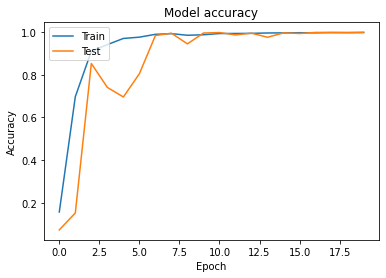

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



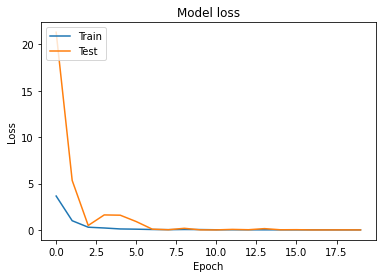

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()